# Powerlytics - Insurance Use Case

### Load the Insurance Carrier Data set

The insurance carrier dataset contains buyers/non-buyers of a second product, which is a target variable, along with other customer specific variables. Powerlytics developed a cross-sell score that was highly predictive in identifying customers most likely to buy a second product. The data features contains cross-sell score along with other customer specific econometrics variables from Powerlytics database. This notebook demonstartes a usecase to identify and consolidate key drivers from the dataset, implement multivariate machine learning model, predict the propensity to buy next product and evaluate Lift and customer capture rate on original and holdout datasets.

Install and load the necessary Python modules

In [1]:
import pandas as pd
import numpy as np
import h2o 
from h2o.estimators import H2OXGBoostEstimator

Let us load the data set

In [2]:
ins = pd.read_csv('data/insurance_original.csv')

### Intialize the H2O

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/ndingari/anaconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpe10gl29x
  JVM stdout: /tmp/tmpe10gl29x/h2o_ndingari_started_from_python.out
  JVM stderr: /tmp/tmpe10gl29x/h2o_ndingari_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_ndingari_sfxn8s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.516 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
h2o.remove_all()

### Preprocess the data

Let us preprocess the data and create training and test datasets for model training and evaluation.

In [5]:
ins_h2o = h2o.H2OFrame(ins)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
ins_h2o['bought_nextpol'] = ins_h2o['bought_nextpol'].asfactor()

ins_h2o['gender'] = ins_h2o['gender'].asfactor()
ins_h2o['age'] = ins_h2o['age'].asfactor()
ins_h2o['faceamount'] = ins_h2o['faceamount'].asfactor()
ins_h2o['product'] = ins_h2o['product'].asfactor()
ins_h2o['councilstatus'] = ins_h2o['councilstatus'].asfactor()

ins_h2o_train, ins_h2o_test = ins_h2o.split_frame(ratios=[.8])

ins_h2o_y = 'bought_nextpol'
ins_h2o_x = list(set(ins_h2o.names) - set([ins_h2o_y,'unique_id','zip5','zip4']))

### XGBoost Model Training

We will be using XGBoost for this usecase. XGBoost is a supervised learning algorithm that implements a process called boosting to yield accurate models. Boosting refers to the ensemble learning technique of building many models sequentially,
with each new model attempting to correct for the deficiencies in the previous model.
Note: We are using `max_runtime_secs = 300` to complete the training step in 5 minutes. For better results, please do not use the parameter.

In [7]:
ins_h2o_xgb = H2OXGBoostEstimator(distribution = "bernoulli",
                      ntrees = 1500,
                      max_depth = 5,
                      min_rows = 120,
                      learn_rate = 0.05,
                      nfolds = 10,
                      subsample = 0.75,
                      gamma = 11.0,
                      min_child_weight = 120,
                      colsample_bytree = 0.75,
                      fold_assignment = "Modulo",
                      stopping_metric = "AUC",
                      stopping_rounds = 5,
                      score_tree_interval = 10,
                      keep_cross_validation_predictions = True,
                      seed = 2021,
                      max_runtime_secs = 300)

In [8]:
ins_h2o_xgb.train(x = ins_h2o_x,
                  y = ins_h2o_y,
                  training_frame = ins_h2o_train,
                  validation_frame = ins_h2o_test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


### Display the model learning plot

The learning curve plot shows error metric dependence on learning progress.

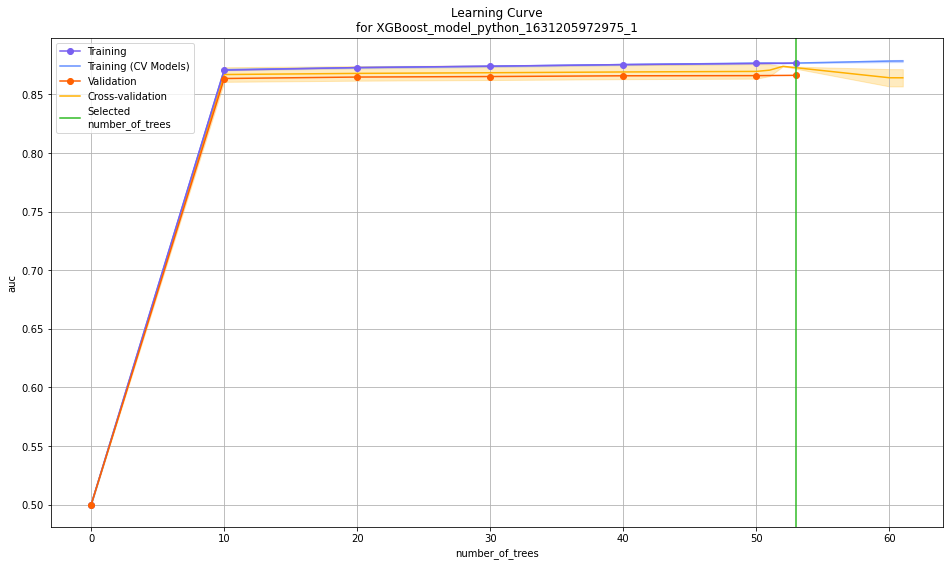

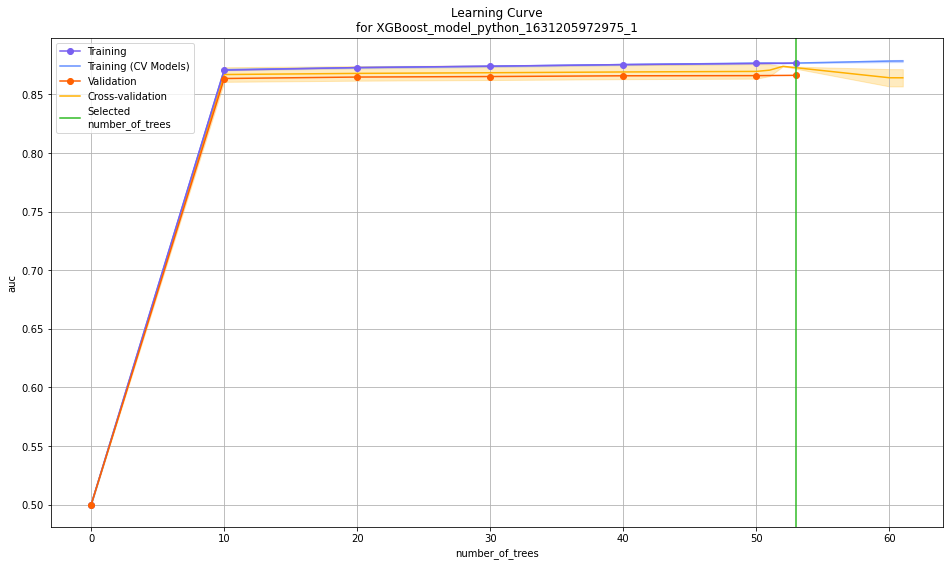

In [9]:
ins_h2o_xgb.learning_curve_plot(metric='auc')

### Display the Variable Importance Table

Display the key drivers/variables that contribute to decision making.

In [10]:
varimp_ins_xgb = ins_h2o_xgb.varimp(use_pandas=True)
varimp_ins_xgb['variable'] = varimp_ins_xgb['variable'].str.split('.').str[0]
varimp_ins_xgb = varimp_ins_xgb[['variable','percentage']].groupby('variable').mean().reset_index()
varimp_ins_xgb.sort_values(['percentage'],ascending=False)

,variable,percentage
0,PWL_CROSSSELL_SCORE,0.900819
241,product,0.014564
30,age,0.003942
236,cluster_total_e87520,0.001417
14,adult_avg_Overpayments_refunded,0.001029
...,...,...
3,adult_avg_Count_of_returns_with_AGI,0.000087
140,cluster_Pct_of_AGI_Total_gifts_to_charity,0.000086
133,cluster_Count_of_returns_with_paid_preparer_s_...,0.000086
46,avg_3_Year_Percent_Change_in_Retirement_Income,0.000084


### Evaluate the model performance on training and test data

In [11]:
ins_xgb_train = ins_h2o_xgb.model_performance(ins_h2o_train)
ins_xgb_test = ins_h2o_xgb.model_performance(ins_h2o_test)

#### Evaluate Training Data AUC

AUC metric is used to evaluate how well a binary classification model is able to distinguish between true positives and false positives. An AUC of 1 indicates a perfect classifier, while an AUC of .5 indicates a poor classifier, whose performance is no better than random guessing.

In [12]:
ins_xgb_train.auc()

0.8766610578349424

#### Evaluate Test Data AUC

In [13]:
ins_xgb_test.auc()

0.8662214817046564

### Predicting on the whole data

In [14]:
ins_pred_xgb = ins_h2o_xgb.predict(ins_h2o)
ins_pred_xgb

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.12772,0.87228
0,0.687004,0.312996
0,0.868271,0.131729
1,0.21663,0.78337
0,0.851098,0.148902
0,0.863172,0.136828
0,0.885111,0.114889
1,0.121775,0.878225
1,0.199925,0.800075
0,0.842821,0.157179


In [15]:
ins_predicted = ins_pred_xgb.as_data_frame()
ins_predicted['bought_nextpol'] = ins['bought_nextpol']
ins_predicted['Group'] = 11-pd.qcut(ins_predicted['p1'], q=10, labels = [1,2,3,4,5,6,7,8,9,10]).astype(int)

In [16]:
ins_predicted

,predict,p0,p1,bought_nextpol,Group
0,1,0.127720,0.872280,1,1
1,0,0.687004,0.312996,0,5
2,0,0.868271,0.131729,0,8
3,1,0.216630,0.783370,1,2
4,0,0.851098,0.148902,0,8
...,...,...,...,...,...
45272,0,0.901499,0.098501,0,9
45273,0,0.853473,0.146527,0,8
45274,0,0.650601,0.349399,1,5
45275,0,0.811179,0.188821,0,7


### Evaluating the Lift and Gain
Gain and Lift charts are used to evaluate performance of classification model. They measure how much better one can expect to do with the predictive model comparing without a model. Gain at a given decile level is the ratio of cumulative number of targets (events) up to that decile to the total number of targets (events) in the entire data set. Lift measures how much better one can expect to do with the predictive model comparing without a model. It is the ratio of gain $\%$ to the random expectation $\%$ at a given decile level. The random expectation at the $x^{th}$ decile is $x\%$.

In [17]:
ins_gainsLift = ins_predicted.groupby(['Group']).agg(num_of_obs = ('predict','count'),
                                                    num_of_responses = ('bought_nextpol','sum')).reset_index()
ins_gainsLift

,Group,num_of_obs,num_of_responses
0,1,4528,4162
1,2,4528,3678
2,3,4527,3087
3,4,4528,2260
4,5,4527,1531
5,6,4528,981
6,7,4528,601
7,8,4527,418
8,9,4528,254
9,10,4528,150


In [18]:
ins_gainsLift = ins_gainsLift.assign(
                    percentage_data = 10*ins_gainsLift['Group'],
                    cum_responses = ins_gainsLift['num_of_responses'].cumsum(),
                    cum_observations = ins_gainsLift['num_of_obs'].cumsum())
ins_gainsLift = ins_gainsLift.assign(
                    Gain = np.round(ins_gainsLift['cum_responses']*100/np.sum(ins_gainsLift['num_of_responses']), 2))
ins_gainsLift = ins_gainsLift.assign(Lift =  np.round(ins_gainsLift['Gain']/(10*ins_gainsLift['Group']), 2))
ins_gainsLift

,Group,num_of_obs,num_of_responses,percentage_data,cum_responses,cum_observations,Gain,Lift
0,1,4528,4162,10,4162,4528,24.31,2.43
1,2,4528,3678,20,7840,9056,45.79,2.29
2,3,4527,3087,30,10927,13583,63.82,2.13
3,4,4528,2260,40,13187,18111,77.02,1.93
4,5,4527,1531,50,14718,22638,85.96,1.72
5,6,4528,981,60,15699,27166,91.69,1.53
6,7,4528,601,70,16300,31694,95.20,1.36
7,8,4527,418,80,16718,36221,97.64,1.22
8,9,4528,254,90,16972,40749,99.12,1.10
9,10,4528,150,100,17122,45277,100.00,1.00


### Preprocessing Holdout Data

We will be testing our model on the unseen hold-out data set.

In [19]:
ins_holdout = pd.read_csv('data/insurance_holdout.csv')

In [20]:
ins_holdout_h2o = h2o.H2OFrame(ins_holdout)
ins_holdout_h2o['bought_nextpol'] = ins_holdout_h2o['bought_nextpol'].asfactor()
ins_holdout_h2o['gender'] = ins_holdout_h2o['gender'].asfactor()
ins_holdout_h2o['age'] = ins_holdout_h2o['age'].asfactor()
ins_holdout_h2o['faceamount'] = ins_holdout_h2o['faceamount'].asfactor()
ins_holdout_h2o['product'] = ins_holdout_h2o['product'].asfactor()
ins_holdout_h2o['councilstatus'] = ins_holdout_h2o['councilstatus'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Predict on Holdout Data

In [21]:
ins_holdout_pred_xgb = ins_h2o_xgb.predict(ins_holdout_h2o)

xgboost prediction progress: |████████████████████████████████████████████| 100%


### Evaluating Lift and Gain on Holdout Data

In [22]:
ins_holdout_predicted = ins_holdout_pred_xgb.as_data_frame()
ins_holdout_predicted['bought_nextpol'] = ins_holdout['bought_nextpol']
ins_holdout_predicted['Group'] = 11-pd.qcut(ins_holdout_predicted['p1'], q=10, labels = [1,2,3,4,5,6,7,8,9,10]).astype(int)

In [23]:
ins_holdout_predicted

,predict,p0,p1,bought_nextpol,Group
0,0,0.883905,0.116095,0,7
1,0,0.902693,0.097307,0,9
2,0,0.907007,0.092993,0,9
3,1,0.185335,0.814665,1,1
4,1,0.308102,0.691898,1,2
...,...,...,...,...,...
18078,0,0.914064,0.085936,0,10
18079,1,0.589266,0.410734,1,3
18080,1,0.403295,0.596705,1,2
18081,0,0.898281,0.101719,0,8


In [24]:
ins_holdout_gainsLift = ins_holdout_predicted.groupby(['Group']).agg(num_of_obs = ('predict','count'),
                                                    num_of_responses = ('bought_nextpol','sum')).reset_index()

ins_holdout_gainsLift = ins_holdout_gainsLift.assign(
                    percentage_data = 10*ins_holdout_gainsLift['Group'],
                    cum_responses = ins_holdout_gainsLift['num_of_responses'].cumsum(),
                    cum_observations = ins_holdout_gainsLift['num_of_obs'].cumsum())
ins_holdout_gainsLift = ins_holdout_gainsLift.assign(
                    Gain = np.round(ins_holdout_gainsLift['cum_responses']*100/np.sum(ins_holdout_gainsLift['num_of_responses']), 2))
ins_holdout_gainsLift = ins_holdout_gainsLift.assign(Lift =  np.round(ins_holdout_gainsLift['Gain']/(10*ins_holdout_gainsLift['Group']), 2))
ins_holdout_gainsLift

,Group,num_of_obs,num_of_responses,percentage_data,cum_responses,cum_observations,Gain,Lift
0,1,1809,1609,10,1609,1809,27.09,2.71
1,2,1808,1371,20,2980,3617,50.18,2.51
2,3,1808,1057,30,4037,5425,67.97,2.27
3,4,1808,751,40,4788,7233,80.62,2.02
4,5,1808,415,50,5203,9041,87.61,1.75
5,6,1809,272,60,5475,10850,92.19,1.54
6,7,1808,176,70,5651,12658,95.15,1.36
7,8,1808,128,80,5779,14466,97.31,1.22
8,9,1805,87,90,5866,16271,98.77,1.10
9,10,1812,73,100,5939,18083,100.00,1.00


Powerlytics data could play a key role in helping Insurance Carrier build a data driven process to increase their share of wallet with current policyholders. Our analysis could also identify next best product offers and provide tools for Agents to identify policyholders more likely to purchase an additional product.

### Shut Down H2O

In [25]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_894a closed.
